# Circuit library

The Qiskit SDK includes a library of popular circuits to use as building blocks in your own programs. Using pre-defined circuits saves time researching, writing code, and debugging. The library includes popular circuits in quantum computing, circuits that are difficult to simulate classically, and circuits useful for quantum hardware benchmarking.

This page lists the different circuit categories the library provides. For a full list of circuits, see thy [circuit library API documentation](/api/qiskit/circuit_library).

## N-local circuits

These circuits alternate layers of single-qubit rotation gates with layers of multi-qubit entangling gates.

This family of circuits is popular in variational quantum algorithms because they can produce a wide range of quantum states. Variational algorithms adjust the gate parameters to find states that have certain properties (such as states that represent a good solution to an optimization problem). For this purpose, many circuits in the library are **parameterized**, which means you can define them without fixed values.

The following code cell imports a `TwoLocal` circuit, in which the entangling gates are two-qubit gates. This circuit interleaves blocks of parameterized single-qubit gates, followed by entangling blocks of two-qubit gates. The following code creates a three-qubit circuit, with single-qubit RX-gates and two-qubit CZ-gates.

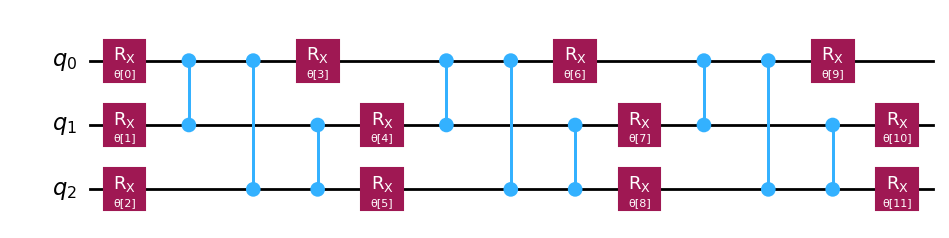

In [1]:
from qiskit.circuit.library import TwoLocal
two_local = TwoLocal(3, 'rx', 'cz')
two_local.decompose().draw('mpl')

You can get a list-like object of the circuit's parameters from the `parameters` attribute.

In [2]:
two_local.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11])])

You can also use this to assign these parameters to real values using a dictionary of the form `{ Parameter: number }`. To demonstrate, the following code cell assigns each parameter in the circuit to `0`.

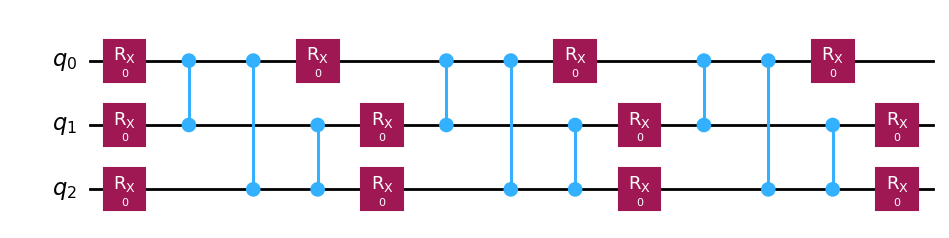

In [3]:
bound_circuit = two_local.assign_parameters({ p: 0 for p in two_local.parameters})
bound_circuit.decompose().draw('mpl')

For more information, see [N-local gates](/api/qiskit/circuit_library#n-local-circuits) in the circuit library API documentation or take our [Variational algorithm design course](https://learning.quantum.ibm.com/course/variational-algorithm-design).

## Data-encoding circuits

These parameterized circuits encode data onto quantum states for processing by quantum machine learning algorithms. Some circuits supported by Qiskit are:
 - Amplitude encoding, which encodes each number into the amplitude of a basis state. This can store $2^n$ numbers in a single state, but can be costly to implement.
 - Basis encoding, which encodes an integer $k$ by preparing the corresponding basis state $|k\rangle$.
 - Angle encoding, which sets each number in the data as a rotation angle in a parameterized circuit.

The best approach depends upon the specifics of your application. On current quantum computers, however, we often use angle-encoding circuits such as the `ZZFeatureMap`.

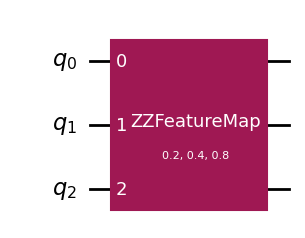

In [4]:
from qiskit.circuit.library import ZZFeatureMap

features = [0.2, 0.4, 0.8]
feature_map = ZZFeatureMap(feature_dimension=len(features))

encoded = feature_map.assign_parameters(features)
encoded.draw('mpl')

See [Data encoding circuits](/api/qiskit/circuit_library#data-encoding-circuits) in the circuit library API documentation.

## Time-evolution circuits

These circuits simulate a quantum state evolving in time. Use time-evolution circuits to investigate physical effects such as heat transfer or phase transitions in a system. Time-evolution circuits are also a fundamental building block of chemistry wave functions (such as unitary coupled-cluster trial states) and of the QAOA algorithm we use for optimization problems.

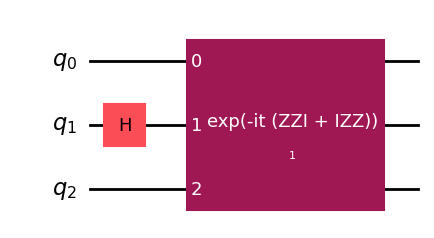

In [5]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp


# Prepare an initial state with a Hamadard on the middle qubit
state = QuantumCircuit(3)
state.h(1)

hamiltonian = SparsePauliOp(["ZZI", "IZZ"])
evolution = PauliEvolutionGate(hamiltonian, time=1)

# Evolve state by appending the evolution gate
state.compose(evolution, inplace=True)

state.draw('mpl')

Read the [`PauliEvolutionGate` API documentation](/api/qiskit/qiskit.circuit.library.PauliEvolutionGate).

## Benchmarking and complexity-theory circuits

Benchmarking circuits give us a sense of how well our hardware is actually working, and complexity-theory circuits help us understand how difficult the problems we want to solve are.

For example, the "quantum volume" benchmark measures how accurately a quantum computer executes a type of random quantum circuit. The score of the quantum computer increases with the size of the circuit it can reliably run. This takes into account all aspects of the computer, including qubit count, instruction fidelity, qubit connectivity, and the software stack transpiling and post-processing results. Read more about quantum volume in the original [quantum volume paper](https://arxiv.org/abs/1811.12926).

The following code shows an example of a quantum volume circuit built in Qiskit that runs on four qubits (the `su4_` blocks are randomized two-qubit gates).

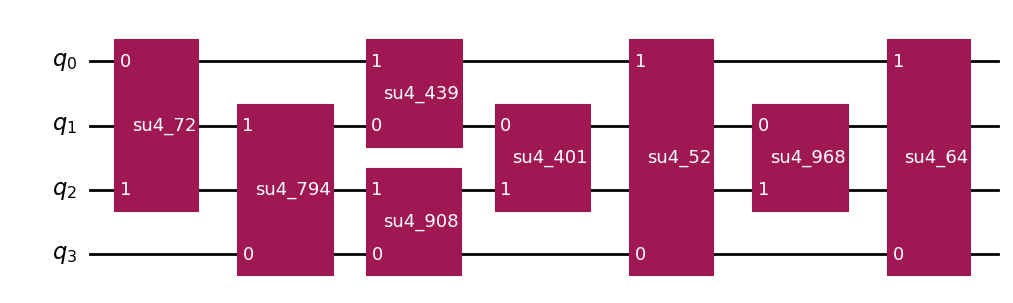

In [6]:
from qiskit.circuit.library import QuantumVolume
QuantumVolume(4).decompose().draw('mpl')

The circuit library also includes circuits believed to be hard to simulate classically, such as instantaneous quantum polynomial (IQP) circuits. These circuits sandwich certain diagonal gates (in the computational basis) between blocks of Hadamard gates.

Other circuits include `GroverOperator` for use in Grover's algorithm, and the `FourierChecking` circuit for the Fourier checking problem. See these circuits in [Particular quantum circuits](/api/qiskit/circuit_library#particular-quantum-circuits) in the circuit library API documentation.

## Arithmetic circuits

Arithmetic operations are classical functions, such as adding integers and bit-wise operations. These may be useful with algorithms such as amplitude estimation for finance applications, and in algorithms like the HHL algorithm, which solves linear systems of equations.

As an example, let’s try adding two three-bit numbers using a "ripple-carry" circuit to perform in-place addition (`CDKMRippleCarryAdder`). This adder adds two numbers (we'll call them "A" and "B") and writes the result to the register that held B. In the following example, A=2 and B=3.

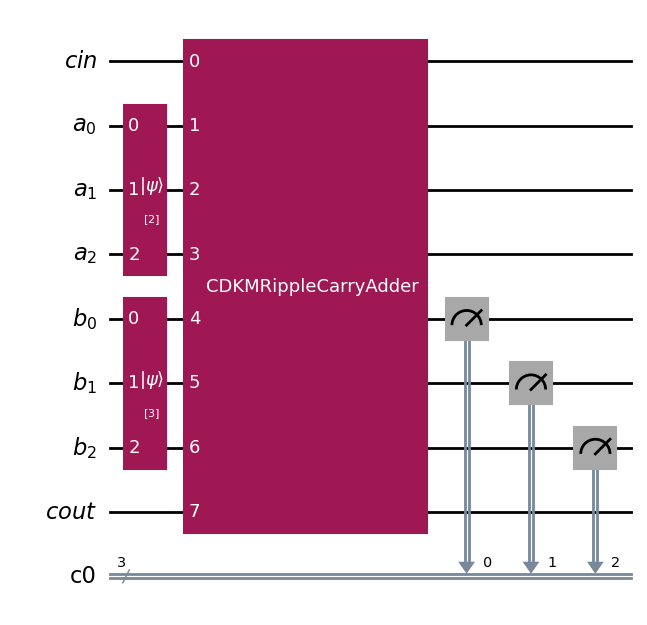

In [7]:
from qiskit.circuit.library import CDKMRippleCarryAdder
adder = CDKMRippleCarryAdder(3)  # Adder of 3-bit numbers

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Create the number A=2
reg_a = QuantumRegister(3, 'a')
number_a = QuantumCircuit(reg_a)
number_a.initialize(2) # Number 2; |010>

# Create the number B=3
reg_b = QuantumRegister(3, 'b')
number_b = QuantumCircuit(reg_b)
number_b.initialize(3)  # Number 3; |011>

# Create a circuit to hold everything, including a classical register for
# the result
reg_result = ClassicalRegister(3)
circuit = QuantumCircuit(*adder.qregs, reg_result)

# Compose number initializers with the adder. Adder stores the result to
# register B, so we'll measure those qubits.
circuit = circuit.compose(number_a, qubits=reg_a).compose(number_b, qubits=reg_b).compose(adder)
circuit.measure(reg_b, reg_result)
circuit.draw('mpl')

Simulating the circuit shows that it outputs `5` (with probability `1.0`).

In [8]:
from qiskit.primitives import Sampler

result = Sampler().run(circuit).result()
result.quasi_dists[0]

{5: 1.0}

See [Arithmetic circuits](/api/qiskit/circuit_library#arithmetic-circuits) in the circuit library API documentation.

## Standard gates

The circuit library also includes standard quantum gates. Some are more fundamental gates (such as the `UGate`), and others are multi-qubit gates that usually need building from single- and two-qubit gates. To add imported gates to your circuit, use the `append` method; the first argument is the gate, and the next argument is a list of qubits to apply the gate to.

For example, the following code cell creates a circuit with a Hadamard gate and a multi-controlled-X gate.

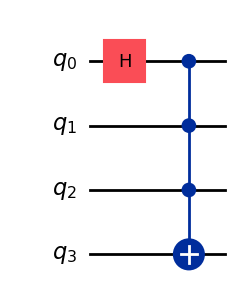

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, MCXGate
mcx_gate = MCXGate(3)
hadamard_gate = HGate()

qc = QuantumCircuit(4)
qc.append(hadamard_gate, [0])
qc.append(mcx_gate, [0,1,2,3])
qc.draw('mpl')

See [Standard gates](/api/qiskit/circuit_library#standard-gates) in the circuit library API documentation.

## Next steps

<Admonition type="tip" title="Recommendations">
  -  Learn advanced methods for creating circuits in the [Construct circuits](circuit-construction) topic.
  -  See an example of circuits being used in the [Grover's Algorithm](https://learning.quantum.ibm.com/tutorial/grovers-algorithm) tutorial.
  -  Review the [circuit library API](/api/qiskit/circuit_library) reference.
</Admonition>